# Quickstart - Run TiRex on GiftEval

This notebook shows how to run [TiRex](https://github.com/NX-AI/tirex) on the gift-eval benchmark.

Make sure you download the gift-eval benchmark and set the `GIFT-EVAL` environment variable correctly before running this notebook.


## Setup Instructions

Before proceeding, ensure you have the following:
(Note: You need a Nvidia GPU with [CUDA compute capabality >= 8.0](https://developer.nvidia.com/cuda-gpus))

1. **Optional but suggested: Install conda environment specifed in TiRex Repo**

```bash
git clone github.com/NX-AI/tirex
conda env create --file ./tirex/requirements_py26.yaml
conda activate tirex
```

2. **Install TiRex**

```bash
git clone github.com/NX-AI/tirex  # if not cloned before
cd tirex
pip install .  # install tirex
```

3. **Install additional dependecies needed for GiftEval benchmark**

```bash
pip install gluonts dotenv datasets
```

In [ ]:
#
# This is the data.py file as in GiftEval but fixed so that one can run it with numpy >2.0.0
# (Extended/Fixed the frequency alias)
#

import os
import math
from functools import cached_property
from enum import Enum
from pathlib import Path
import sys
from typing import Iterable, Iterator

import datasets
from dotenv import load_dotenv
from gluonts.dataset import DataEntry
from gluonts.dataset.common import ProcessDataEntry
from gluonts.dataset.split import TestData, TrainingDataset, split
from gluonts.itertools import Map
from gluonts.time_feature import norm_freq_str
from gluonts.transform import Transformation
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset
import pyarrow.compute as pc
from toolz import compose

sys.path.append('../src')
from timesc.metalog import *
from timesc.generate_ts import *

TEST_SPLIT = 0.1
MAX_WINDOW = 20

M4_PRED_LENGTH_MAP = {
    "A": 6,
    "Q": 8,
    "M": 18,
    "W": 13,
    "D": 14,
    "H": 48,
    # new version fix:
    "h": 48,
    "Y": 6,

}

PRED_LENGTH_MAP = {
    "M": 12,
    "W": 8,
    "D": 30,
    "H": 48,
    "T": 48,
    "S": 60,
    # new version fix:
    "h": 48,
    "s": 60,
    "min": 48,
}

TFB_PRED_LENGTH_MAP = {
    "A": 6,
    "H": 48,
    "Q": 8,
    "D": 14,
    "M": 18,
    "W": 13,
    "U": 8,
    "T": 8,
    # new version fix:
    "min": 8,
    "us": 8,
    "Y": 6,
    "h": 48,
}


class Term(Enum):
    SHORT = "short"
    MEDIUM = "medium"
    LONG = "long"

    @property
    def multiplier(self) -> int:
        if self == Term.SHORT:
            return 1
        elif self == Term.MEDIUM:
            return 10
        elif self == Term.LONG:
            return 15


def itemize_start(data_entry: DataEntry) -> DataEntry:
    data_entry["start"] = data_entry["start"].item()
    return data_entry


class MultivariateToUnivariate(Transformation):
    def __init__(self, field):
        self.field = field

    def __call__(
        self, data_it: Iterable[DataEntry], is_train: bool = False
    ) -> Iterator:
        for data_entry in data_it:
            item_id = data_entry["item_id"]
            val_ls = list(data_entry[self.field])
            for id, val in enumerate(val_ls):
                univariate_entry = data_entry.copy()
                univariate_entry[self.field] = val
                univariate_entry["item_id"] = item_id + "_dim" + str(id)
                yield univariate_entry


class Dataset:
    def __init__(
        self,
        name: str,
        term: Term | str = Term.SHORT,
        to_univariate: bool = False,
        storage_env_var: str = "GIFT_EVAL",
    ):
        load_dotenv()
        storage_path = Path('/mnt/data_1/home_tsteam/gift-eval') # os.getenv(storage_env_var))
        self.hf_dataset = datasets.load_from_disk(str(storage_path / name)).with_format(
            "numpy"
        )
        process = ProcessDataEntry(
            self.freq,
            one_dim_target=self.target_dim == 1,
        )

        self.gluonts_dataset = Map(compose(process, itemize_start), self.hf_dataset)
        if to_univariate:
            self.gluonts_dataset = MultivariateToUnivariate("target").apply(
                self.gluonts_dataset
            )

        self.term = Term(term)
        self.name = name

    @cached_property
    def prediction_length(self) -> int:
        freq = norm_freq_str(to_offset(self.freq).name)
        if freq.endswith("E"):
            freq = freq[:-1]
        pred_len = (
            M4_PRED_LENGTH_MAP[freq] if "m4" in self.name else PRED_LENGTH_MAP[freq]
        )
        return self.term.multiplier * pred_len

    @cached_property
    def freq(self) -> str:
        return self.hf_dataset[0]["freq"]

    @cached_property
    def target_dim(self) -> int:
        return (
            target.shape[0]
            if len((target := self.hf_dataset[0]["target"]).shape) > 1
            else 1
        )

    @cached_property
    def past_feat_dynamic_real_dim(self) -> int:
        if "past_feat_dynamic_real" not in self.hf_dataset[0]:
            return 0
        elif (
            len(
                (
                    past_feat_dynamic_real := self.hf_dataset[0][
                        "past_feat_dynamic_real"
                    ]
                ).shape
            )
            > 1
        ):
            return past_feat_dynamic_real.shape[0]
        else:
            return 1

    @cached_property
    def windows(self) -> int:
        if "m4" in self.name:
            return 1
        w = math.ceil(TEST_SPLIT * self._min_series_length / self.prediction_length)
        return min(max(1, w), MAX_WINDOW)

    @cached_property
    def _min_series_length(self) -> int:
        if self.hf_dataset[0]["target"].ndim > 1:
            lengths = pc.list_value_length(
                pc.list_flatten(
                    pc.list_slice(self.hf_dataset.data.column("target"), 0, 1)
                )
            )
        else:
            lengths = pc.list_value_length(self.hf_dataset.data.column("target"))
        return min(lengths.to_numpy())

    @cached_property
    def sum_series_length(self) -> int:
        if self.hf_dataset[0]["target"].ndim > 1:
            lengths = pc.list_value_length(
                pc.list_flatten(self.hf_dataset.data.column("target"))
            )
        else:
            lengths = pc.list_value_length(self.hf_dataset.data.column("target"))
        return sum(lengths.to_numpy())

    @property
    def training_dataset(self) -> TrainingDataset:
        training_dataset, _ = split(
            self.gluonts_dataset, offset=-self.prediction_length * (self.windows + 1)
        )
        return training_dataset

    @property
    def validation_dataset(self) -> TrainingDataset:
        validation_dataset, _ = split(
            self.gluonts_dataset, offset=-self.prediction_length * self.windows
        )
        return validation_dataset

    @property
    def test_data(self) -> TestData:
        _, test_template = split(
            self.gluonts_dataset, offset=-self.prediction_length * self.windows
        )
        test_data = test_template.generate_instances(
            prediction_length=self.prediction_length,
            windows=self.windows,
            distance=self.prediction_length,
        )
        return test_data

/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


### This Runs the Evalutions 
(make sure to execute the blocks before to init all depdent classes)

In [ ]:
import os
import pandas as pd
from tirex import load_model, ForecastModel

model: ForecastModel = load_model("NX-AI/TiRex", device="cuda:3")

Using /mnt/data_1/home_tsteam/.cache/torch_extensions/py311_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /mnt/data_1/home_tsteam/.cache/torch_extensions/py311_cu126/slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/xlstm/blocks/slstm/ce

ninja: no work to do.


Using /mnt/data_1/home_tsteam/.cache/torch_extensions/py311_cu126 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Using /mnt/data_1/home_tsteam/.cache/torch_extensions/py311_cu126 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Using /mnt/data_1/home_tsteam/.cache/torch_extensions/py311_cu126 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d

In [51]:
def quantile_trajectory_sampling(X_full, C, P, prediction_fn):

    F = 0
    Ymt = np.concatenate(
        [
            np.repeat(X_full[:, : C + F, None], 9, axis=2),
            prediction_fn(
                torch.Tensor(X_full[:, : C + F]),
            ).swapaxes(
                1, 2
            )[:, : P - F],
        ],
        axis=1,
    )

    Y = np.repeat(X_full[:, None, :C], 100, axis=1)
    # Y[:,:,-1] += np.random.normal(0,0.01, Y.shape[:2])
    W = np.zeros(Y.shape[:2] + (P,), dtype=int)

    T = 1.0
    preds = []
    full_ymt = []
    for i in range(P):
        # if i < F:
        #     Y = np.concatenate([
        #         Y,
        #         np.repeat(X_full[:, None, C+i:C+i+1], 100, axis=1)
        #     ], axis=-1)
        #     continue

        Y = Y.reshape(1, -1, Y.shape[-1])

        print(i)

        y_mt = prediction_fn(
            torch.Tensor(Y[0]),
        )[None, :, :]
        y = y_mt[0, :, :, 0]

        preds.append(y.reshape(-1, 100, 9))

        y_mt = np.concatenate(
            [
                np.repeat(Y[:, :, :, None], 9, axis=3),
                y_mt.swapaxes(2, 3),
            ],
            axis=2,
        )

        full_ymt.append(y_mt[0, :, C : C + P, :].reshape(-1, 100, P, 9))

        if i > 0:

            subset = np.random.choice(100, 20, replace=False)
            subset_q = np.random.choice(9 * 100, 9 * 20, replace=False)

            Qtrue, Qemp = (
                # Ymt[:, C + i, :],
                np.quantile(
                    np.array(full_ymt[0:-1])[:, :, :, i, :]
                    .swapaxes(0, 1)
                    .reshape(64, -1),
                    np.linspace(0.1, 0.9, 9),
                    axis=1,
                ).T,
                np.quantile(
                    full_ymt[-1][:, :, i, :].reshape(64, -1)[:, :],
                    np.linspace(0.1, 0.9, 9),
                    axis=1,
                ).T,
            )

            A = np.sum(
                (Qemp - np.mean(Qemp, axis=1, keepdims=True))
                * (Qtrue - np.mean(Qtrue, axis=1, keepdims=True)),
                axis=1,
            ) / np.sum((Qemp - np.mean(Qemp, axis=1, keepdims=True)) ** 2, axis=1)

            B = np.mean(Qtrue, axis=1) - A * np.mean(Qemp, axis=1)

            A, B = A[:, None, None], B[:, None, None]

            y = y.reshape(-1, 100, 9)
            # y = y + 0.01 ** ((i + 1) / P) * ((A - np.ones_like(A)) * y + B)
            # y += Score_t.T.mean(axis=1) # Score_t[:, None, :]
            # y[:, subset, :] = y[:, subset, :] + (
            #     (A - np.ones_like(A)) * y[:, subset, :] + B
            # )
            y = y.reshape(-1, 9)

        sampled = []
        for ys, ymt in zip(y, np.repeat(Ymt[:, C + i], 100, axis=0)):
            Qs, itransform = transform(ys)
            ridge_reg = 1e-7
            try:
                s = tempered_metalog_from_quantiles(
                    np.linspace(0.1, 0.9, 9),
                    Qs,
                    T,
                    n_integration=10001,
                    ridge=ridge_reg,
                )[0](np.random.uniform(0, 1, 1))[None, None, :]
            except:
                ridge_reg = 1e-1
                try:
                    s = tempered_metalog_from_quantiles(
                        np.linspace(0.1, 0.9, 9),
                        Qs,
                        T,
                        n_integration=10001,
                        ridge=ridge_reg,
                    )[0](np.random.uniform(0, 1, 1))[None, None, :]
                except:
                    ridge_reg = 1e0
                    try:
                        s = tempered_metalog_from_quantiles(
                            np.linspace(0.1, 0.9, 9),
                            Qs,
                            T,
                            n_integration=10001,
                            ridge=ridge_reg,
                        )[0](np.random.uniform(0, 1, 1))[None, None, :]
                    except:
                        ridge_reg = 1e6
                        s = tempered_metalog_from_quantiles(
                            np.linspace(0.1, 0.9, 9),
                            Qs,
                            T,
                            n_integration=10001,
                            ridge=ridge_reg,
                        )[0](np.random.uniform(0, 1, 1))[None, None, :]

            sampled.append(itransform(s))

        y = np.concatenate(sampled, axis=0)
        Y = np.concatenate([Y, y[None, :, 0, :]], axis=-1)

        Y = Y.reshape(-1, 100, Y.shape[-1])

        # for j in range(len(Y)):
        #     bins = np.concatenate([Ymt[j, C + i], np.array([np.inf])])
        #     for k in range(1, len(bins)):
        #         if bins[k - 1] > bins[k]:
        #             bins[k] = bins[k - 1]

        #     digitize = np.digitize(
        #         Y[j, :, C + i],
        #         bins=bins,
        #     )
        #     # bc = np.bincount(digitize) / 100
        #     # W[j, :, i] = np.log(1 / bc)[digitize]

        #     W[j, :, i] = digitize

        # Wbc = np.array(
        #     [
        #         [np.log(1 / np.bincount(wi).astype(float))[wi] for wi in w.T]
        #         for w in W[:, :, : i + 1]
        #     ]
        # )

        # Wbc =

        # Wi = torch.softmax(
        #     torch.Tensor(Wbc.mean(axis=1)) * 0.2,
        #     dim=-1,
        # ).numpy()

        # # Wi = torch.softmax(torch.Tensor(W.mean(axis=2)), dim=-1).numpy()

        # print(np.sort(Wi, axis=1)[:,::-1])

        # Wi = np.

        # S = np.array([np.random.multinomial(1, w, 100).argmax(axis=-1) for w in Wi])

        # Y = np.array([y[s] for y, s in zip(Y, S)])
        # W = np.array([w[s] for w, s in zip(W, S)])

    return Y, Ymt, full_ymt

In [46]:
X_full_full = make_synthetic_series(64, 2000)

### Synthetic data

In [ ]:
import sys

sys.path.append("/mnt/data_1/home_tsteam/malonso/gift-eval/src")

from gift_eval.data import Dataset

import os
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
load_dotenv()

# Get the GIFT_EVAL path from environment variables
gift_eval_path = "/mnt/data_1/home_tsteam/gift-eval"

if gift_eval_path:
    # Convert to Path object for easier manipulation
    gift_eval_path = Path(gift_eval_path)

    # Get all subdirectories (dataset names) in the GIFT_EVAL path
    dataset_names = []
    for dataset_dir in gift_eval_path.iterdir():
        if dataset_dir.name.startswith("."):
            continue
        if dataset_dir.is_dir():
            freq_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
            if freq_dirs:
                for freq_dir in freq_dirs:
                    dataset_names.append(f"{dataset_dir.name}/{freq_dir.name}")
            else:
                dataset_names.append(dataset_dir.name)

    print("Available datasets in GIFT_EVAL:")
    for name in sorted(dataset_names):
        print(f"- {name}")
else:
    print(
        "GIFT_EVAL path not found in environment variables. Please check your .env file."
    )

Available datasets in GIFT_EVAL:
- LOOP_SEATTLE/5T
- LOOP_SEATTLE/D
- LOOP_SEATTLE/H
- M_DENSE/D
- M_DENSE/H
- SZ_TAXI/15T
- SZ_TAXI/H
- artefacts
- bitbrains_fast_storage/5T
- bitbrains_fast_storage/H
- bitbrains_rnd/5T
- bitbrains_rnd/H
- bizitobs_application
- bizitobs_l2c/5T
- bizitobs_l2c/H
- bizitobs_service
- car_parts_with_missing
- cli/conf
- covid_deaths
- dataset/.cache
- dataset/LOOP_SEATTLE
- dataset/M_DENSE
- dataset/SZ_TAXI
- dataset/bitbrains_fast_storage
- dataset/bitbrains_rnd
- dataset/bizitobs_application
- dataset/bizitobs_l2c
- dataset/bizitobs_service
- dataset/car_parts_with_missing
- dataset/covid_deaths
- dataset/electricity
- dataset/ett1
- dataset/ett2
- dataset/hierarchical_sales
- dataset/hospital
- dataset/jena_weather
- dataset/kdd_cup_2018_with_missing
- dataset/m4_daily
- dataset/m4_hourly
- dataset/m4_monthly
- dataset/m4_quarterly
- dataset/m4_weekly
- dataset/m4_yearly
- dataset/restaurant
- dataset/saugeenday
- dataset/solar
- dataset/temperature_r

In [ ]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

ds_name = "ett1/H"  # Name of the dataset
to_univariate = True  # Whether to convert the data to univariate
term = "short"  # Term of the dataset

dataset = Dataset(name=ds_name, term=term, to_univariate=to_univariate)
print("Dataset frequency: ", dataset.freq)
print("Prediction length: ", dataset.prediction_length)
print("Number of windows in the rolling evaluation: ", dataset.windows)

Dataset frequency:  H
Prediction length:  48
Number of windows in the rolling evaluation:  20


/tmp/ipykernel_3638696/4070019332.py:137: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = norm_freq_str(to_offset(self.freq).name)


Keys in the validation data:  dict_keys(['item_id', 'start', 'freq', 'target'])
Item id:  item_0_dim5
Start Date:  2016-07-01 00:00
Frequency:  H
Last 10 target values:  [4.934     4.6289997 4.904     4.507     4.538     4.5690002 4.051
 3.96      3.8070002 3.075    ]


/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


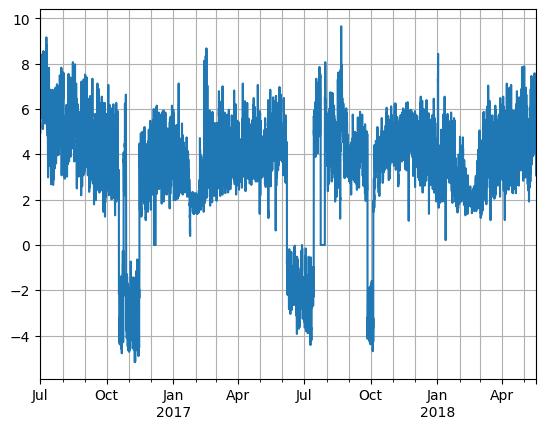

In [ ]:
val_data_iter = dataset.validation_dataset

for i, val_data in zip(range(np.random.randint(len(val_data_iter))+1), val_data_iter):
    pass

print("Keys in the validation data: ", val_data.keys())

print("Item id: ", val_data["item_id"])
print("Start Date: ", val_data["start"])
print("Frequency: ", val_data["freq"])
print("Last 10 target values: ", val_data["target"][-10:])

val_series = to_pandas(val_data)
val_series.plot()
plt.grid(which="both")
plt.show()

In [12]:
# val_data_iter = dataset.validation_dataset

# for i, val_data in zip(range(np.random.randint(len(val_data_iter)) + 1), val_data_iter):
#     pass

# val_series = to_pandas(val_data)

# X_full_full = val_series.values[None, :]

### Define prediction task

In [ ]:
C = 512 # context length
P = 64 # prediction length
L = C + P

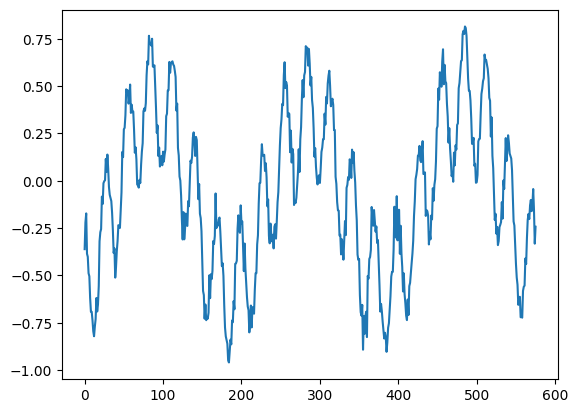

In [ ]:
I = np.random.randint(0, len(X_full_full))
X_full = X_full_full #[I : I + 1]
J = np.random.randint(0, len(X_full[0]) - L)
X_full = X_full[:, J : J + L]
plt.plot(X_full[0])
plt.show()

## Quantile-based trajectory sampling

In [53]:
Y, Ymt, full_ymt = quantile_trajectory_sampling(
    X_full, C, P, lambda x: model._forecast_quantiles(x, prediction_length=P)[0].swapaxes(1, 2).numpy()
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [54]:
pd.DataFrame(
    [
        # np.mean(np.abs(X_full - np.median(Y0, axis=1))[:, C:], axis=1),
        np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:], axis=1),
        np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:], axis=1),
    ]
).T.style.background_gradient(vmin=0, vmax=0.3, cmap="jet")

,0,1
0,0.231071,0.225276
1,0.072491,0.080747
2,0.168812,0.165054
3,0.114089,0.082822
4,0.098063,0.082807
5,0.200671,0.284881
6,0.038706,0.050320
7,0.302247,0.285021
8,0.069062,0.075316
9,0.069795,0.066594


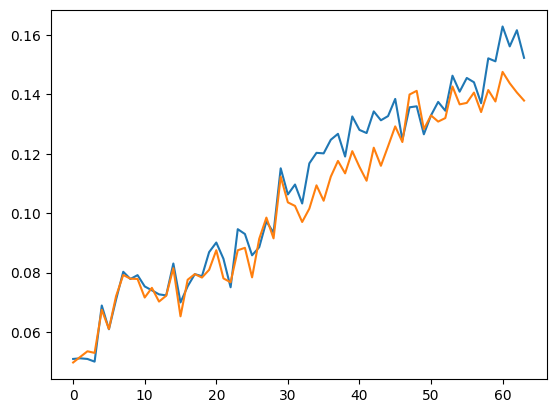

In [55]:
plt.plot(np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:], axis=0))
plt.plot(np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:], axis=0))

In [56]:
print(np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:]))
print(np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:]))
print("--------------")

print(np.mean((np.abs(X_full - np.median(Y, axis=1)) / np.abs(X_full))[:, C:]))
print(np.mean((np.abs(X_full - Ymt[:, :, 4]) / np.abs(X_full))[:, C:]))
print("--------------")

Qs = np.linspace(0.1, 0.9, 9)
diff = X_full - np.quantile(Y, Qs, axis=1)
print(
    np.mean(
        (
            (
                np.maximum(0, diff) * Qs[:, None, None] * 2
                + np.maximum(0, -diff) * (1 - Qs[:, None, None]) * 2
            )
            / np.abs(X_full)
        )[:, :, C:]
    )
)
diff = X_full - np.swapaxes(np.swapaxes(Ymt, 0, 2), 1, 2)
print(
    np.mean(
        (
            (
                np.maximum(0, diff) * Qs[:, None, None] * 2
                + np.maximum(0, -diff) * (1 - Qs[:, None, None]) * 2
            )
            / np.abs(X_full)
        )[:, :, C:]
    )
)

0.10742642420013901
0.10239214
--------------
1.732815018373227
1.5878927
--------------
1.382387830286601
1.2443839149100029


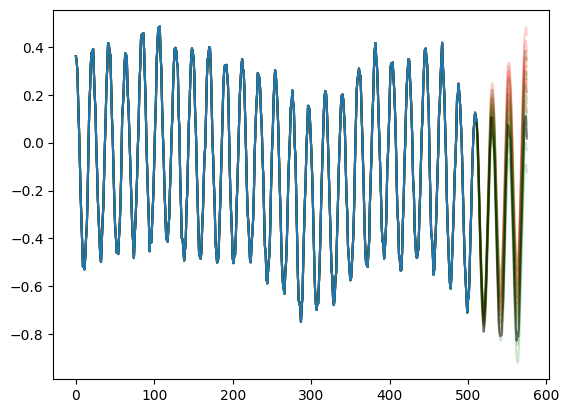

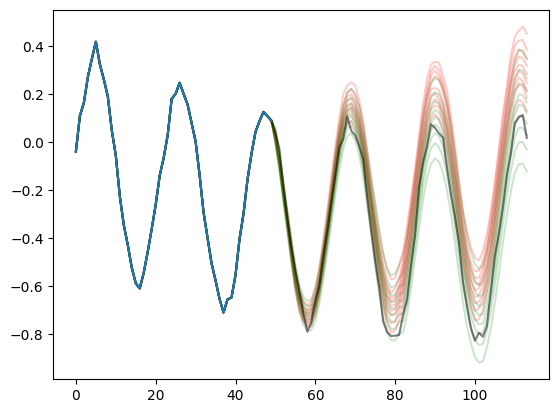

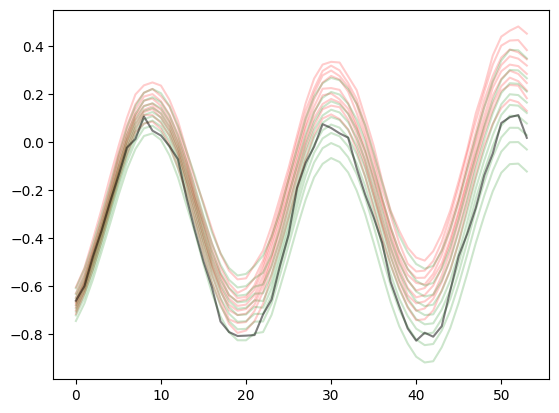

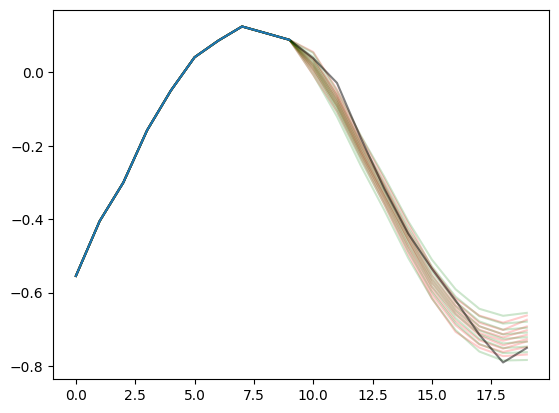

In [58]:
I = 25

plt.plot(np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0).T, color="red", alpha=0.2)
plt.plot(Ymt[I], color="green", alpha=0.2)
plt.plot(X_full[I].T, alpha=0.5, color="black")
plt.plot(X_full[I,:C].T)
plt.show()

plt.plot(
    np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0)[:, C - 50 :].T,
    color="red",
    alpha=0.2,
)
plt.plot(Ymt[I, C - 50 :], color="green", alpha=0.2)
plt.plot(X_full[I, C - 50 :].T, alpha=0.5, color="black")
plt.plot(X_full[I, C - 50 : C].T)
plt.show()

plt.plot(
    np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0)[:, C + 10 :].T,
    color="red",
    alpha=0.2,
)
plt.plot(Ymt[I, C + 10 :], color="green", alpha=0.2)
plt.plot(X_full[I, C + 10 :].T, alpha=0.5, color="black")
plt.plot(X_full[I, C + 10 : C].T)
plt.show()

plt.plot(
    np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0)[:, C - 10 : C + 10].T,
    color="red",
    alpha=0.2,
)
plt.plot(Ymt[I, C - 10 : C + 10], color="green", alpha=0.2)
plt.plot(X_full[I, C - 10 : C + 10].T, alpha=0.5, color="black")
plt.plot(X_full[I, C - 10 : C].T)
plt.show()

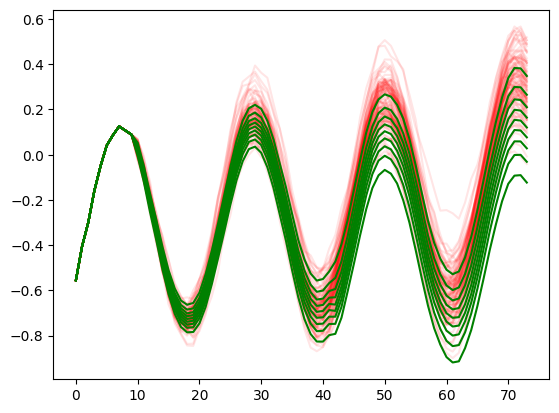

In [71]:
plt.plot(Y[I, :, C-10:].T, alpha=0.1, color='red')
plt.plot(Ymt[I, C - 10 :], color="green", alpha=1)
plt.show()